# Solar panel evaluation

This notebook contains the import and processing of the measured data of the solar panels. This contains also the plotting of the data and the calculation of important KPI's.

### Import data

The next section contains the import of the data and the calculation of the necessary values



In [10]:
import boto3
import pandas
import matplotlib.pyplot as plt

client = boto3.client("iotanalytics")

step=10 # variable to only use every nth meausred data for the plot to make it clearer

def import_data(dataset_name,day,hour, minute):
    data = client.get_dataset_content(datasetName=dataset_name)
    df = pandas.read_csv(data["entries"][0]["dataURI"])# import data
    df["dt"] = pandas.to_datetime(df["timestamp"]) # convert timestamp to datetime
    df.dt = df.dt[0::step] # Only using every nth measured value
    df = df[df["dt"].dt.day == day] # filtering the data according to the desired day
    df = df[df["dt"].dt.hour >= hour] # filtering the data according to the desired hour
    df = df[df["dt"].dt.minute >= minute] # filtering the data according to the desired minute
    df.drop("__dt", axis = 1, inplace = True)
    df.set_index("timestamp", inplace=True) #set timestamp as index
    df=df.sort_index() #sort data by index
    df["energy"]=df.voltage * df.current # calculate current
    return df
    
df_dyn = import_data('pmdyn_dataset',16,12,0) # import the dataframe of the dynamic solar panel

df_sta = import_data('pmsta_dataset',16,12,0) # import the dataframe of the static solar panel







### Plot energy over time

The next section contains the plot of the energy over the time. Both, the dynamic an the static power are plotted in one figure to show the difference between them.

In [11]:
import matplotlib.pyplot as plt
ax = plt.gca()
# plot the energy of static solar panel over time
plt.title("Power of the solar panels", size="25")
df_sta.plot(use_index= True, y="energy",kind="line", color="#00524E", figsize=(20, 10), ax=ax, label="Energy static solar panel")
# plot the energy of dynamic solar panel over time
df_dyn.plot(use_index= True, y="energy",kind="line", color="#00B1AC", figsize=(20, 10), ax=ax, label="Energy dynamic solar panel")

# edit the properties of the plot
plt.xlabel("Time")
plt.ylabel("Energy in mW")
plt.grid()



### Calculation of the KPI's

In [45]:
from statistics import mean

power_cons_servo=-(4*400+3565*6)/3600 # calculation of the power consumption of the servo

power_dyn_mean = round(mean(df_dyn.energy),2)+power_cons_servo # calculating the mean of the created generated power

power_sta_mean = round(mean(df_sta.energy),2) # calculating the mean of the created generated power 


delta_pro = round((power_dyn_mean/power_sta_mean)*100-100,2) # calculating the procentual difference betweend static and dynamic


# printing the KPI's in sentences for an easy viewing
print("Die dynamische Solarzelle hat eine um " + str(delta_pro) + " % höhere Energieausbeute")
print("Durschnittliche Energieausbeute statische Solarzelle: " + str(power_sta_mean) + " mW/h")
print("Durschnittliche Energieausbeute dynmaische Solarzelle: " + str(power_dyn_mean) + " mW/h")


bar = plt.gcf()
plt.bar(["dynamic solar panel","static solar panel"],[power_dyn_mean,power_sta_mean],color="#00B1AC")
plt.bar(0, power_cons_servo, color='r')
plt.ylabel("Power in mW/h")
plt.title("Energy comparison of the two solar panels",size="8")

bar.set_size_inches(5, 6.5)



Die dynamische Solarzelle hat eine um 27.48 % höhere Energieausbeute
Durschnittliche Energieausbeute statische Solarzelle: 166.28 mW/h
Durschnittliche Energieausbeute dynmaische Solarzelle: 211.9738888888889 mW/h


In [47]:
power_dyn_mean = round(mean(df_dyn.energy),2)-500

print("Durschnittliche Energieausbeute dynmaische Solarzelle: " + str(power_dyn_mean) + " mW/h")

power_sta_mean = round(mean(df_sta.energy),2)
print("Durschnittliche Energieausbeute statische Solarzelle: " + str(power_sta_mean) + " mW/h")

delta_pro = round((power_dyn_mean/power_sta_mean)*100-100,2)

print("Die dynamische Solarzelle hat eine um " + str(delta_pro) + " % höhere Energieausbeute")
bar = plt.gcf()
plt.bar(["dynamic solar panel","static solar panel"],[power_dyn_mean,power_sta_mean],color="#00524E")

plt.ylabel("Power in mW/h")
plt.title("Energy comparison of the two solar panels (ESP8266 Power included)",size="8")

bar.set_size_inches(5, 6.5)

Durschnittliche Energieausbeute dynmaische Solarzelle: -281.64 mW/h
Durschnittliche Energieausbeute statische Solarzelle: 166.28 mW/h
Die dynamische Solarzelle hat eine um -269.38 % höhere Energieausbeute


### Reference meausrement

To confirm that the collected data is free from hardware errors a reference measurement was done. Therefore the two panels were placed next to each other in the same angle to get the identic measurement environment. 

Durschnittliche Energieausbeute dynmaische Solarzelle: 172.69 mW/h
Durschnittliche Energieausbeute statische Solarzelle: 175.17 mW/h
Die dynamische Solarzelle hat eine um -1.42 % höhere Energieausbeute


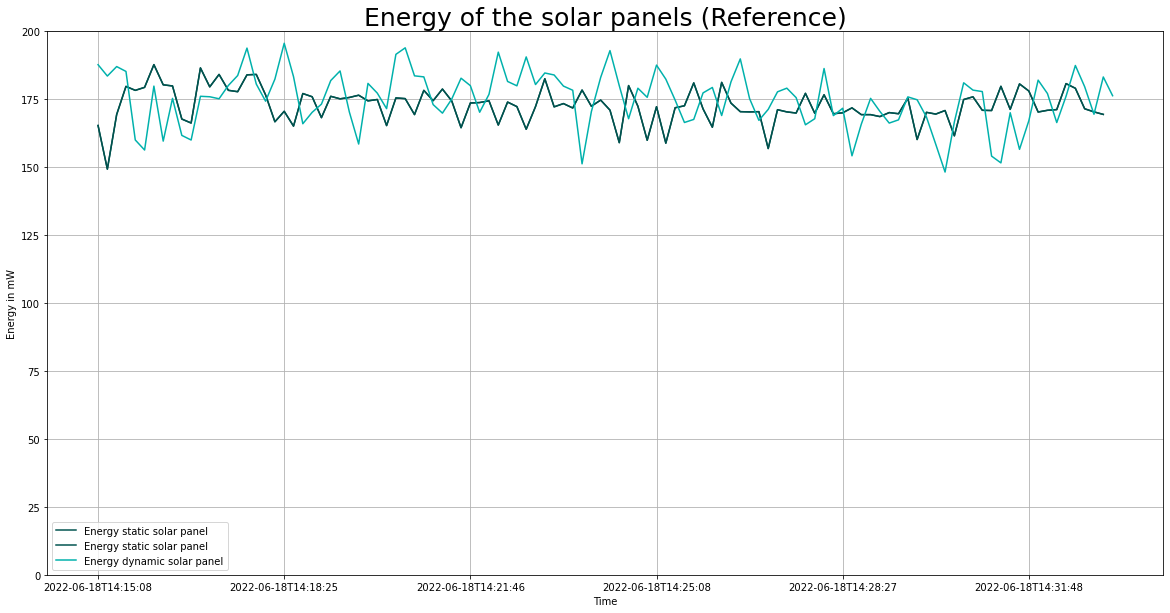

In [50]:
df_dyn_ref = import_data('pmdyn_dataset',18,14,15)
df_sta_ref = import_data('pmsta_dataset',18,14,15)

import matplotlib.pyplot as plt
ax = plt.gca()
# plot the energy of static solar panel over time
plt.title("Energy of the solar panels (Reference)", size="25")
df_dyn_ref.plot(use_index= True, y="energy",kind="line", color="#00524E", figsize=(20, 10), ax=ax, label="Energy static solar panel")
# plot the energy of dynamic solar panel over time
df_dyn_ref.plot(use_index= True, y="energy",kind="line", color="#00524E", figsize=(20, 10), ax=ax, label="Energy static solar panel")
# plot the energy of dynamic solar panel over time
df_sta_ref.plot(use_index= True, y="energy",kind="line", color="#00B1AC", figsize=(20, 10), ax=ax, label="Energy dynamic solar panel")

# edit the properties of the plot
plt.xlabel("Time")
plt.ylabel("Energy in mW")
plt.grid()
plt.ylim(0,200)

power_dyn_mean_ref = round(mean(df_dyn_ref.energy),2)
print("Durschnittliche Energieausbeute dynmaische Solarzelle: " + str(power_dyn_mean_ref) + " mW/h")

power_sta_mean_ref = round(mean(df_sta_ref.energy),2)
print("Durschnittliche Energieausbeute statische Solarzelle: " + str(power_sta_mean_ref) + " mW/h")

delta_pro_ref = round((power_dyn_mean_ref/power_sta_mean_ref)*100-100,2)
print("Die dynamische Solarzelle hat eine um " + str(delta_pro_ref) + " % höhere Energieausbeute")



